# Carla Segmentation

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

from tensorflow import data, keras
from tensorflow.data.experimental import AUTOTUNE

from pathlib import Path
from functools import partial

plt.style.use('ggplot')

In [0]:
!mv kaggle.json /root/.kaggle/
!kaggle datasets download kumaresanmanickavelu/lyft-udacity-challenge
!unzip lyft-udacity-challenge.zip

In [0]:
def process_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, tf.constant([512, 512]))
  image = tf.cast(image * 255, tf.uint8)

  return image

set_path = './dataA/dataA/'
 
def process_path(img_path):
  img_name = tf.strings.split(img_path, '/')[-1]
  
  rgb_image_path = set_path + '/CameraRGB/' + img_name
  seg_image_path = set_path + '/CameraSeg/' + img_name

  seg_img = process_image(seg_image_path)
  seg_shape = seg_img.shape
  seg_img = seg_img[:, :, 0]

  return (process_image(rgb_image_path), seg_img)

def get_data(set_path):
  dataset = data.Dataset.list_files(set_path + '/CameraRGB/*.png')
  dataset = dataset.map(process_path)
  dataset = dataset.prefetch(AUTOTUNE)
  return dataset

full_data = get_data(set_path)
full_data = full_data.shuffle(64)

train_data = full_data.take(600)
remaining = full_data.skip(600)
valid_data = remaining.take(200)
test_data = remaining.skip(200)

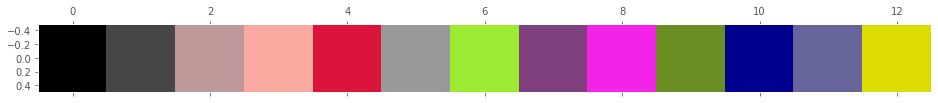

In [143]:
# https://carla.readthedocs.io/en/latest/ref_sensors/#semantic-segmentation-camera
# 0	Unlabeled	( 0, 0, 0)
# 1	Building	( 70, 70, 70)
# 2	Fence	(190, 153, 153)
# 3	Other	(250, 170, 160)
# 4	Pedestrian	(220, 20, 60)
# 5	Pole	(153, 153, 153)
# 6	Road line	(157, 234, 50)
# 7	Road	(128, 64, 128)
# 8	Sidewalk	(244, 35, 232)
# 9	Vegetation	(107, 142, 35)
# 10	Car	( 0, 0, 142)
# 11	Wall	(102, 102, 156)
# 12	Traffic sign	(220, 220, 0)
color_dict = {
  0: [0, 0, 0],
  1: [70, 70, 70],
  2: [190, 153, 153],
  3: [250, 170, 160],
  4: [220, 20, 60],
  5: [153, 153, 153],
  6: [157, 234, 50],
  7: [128, 64, 128],
  8: [244, 35, 232],
  9: [107, 142, 35],
  10: [0, 0, 142],
  11: [102, 102, 156],
  12: [220, 220, 0]
}

color_dict = {k: [x / 255 for x in v] for k, v in color_dict.items()}

cmap = mpl.colors.ListedColormap(color_dict.values())
bounds = tuple(color_dict.keys()) + (13,)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.matshow([list(range(13))], cmap=cmap, norm=norm)
plt.grid(False)

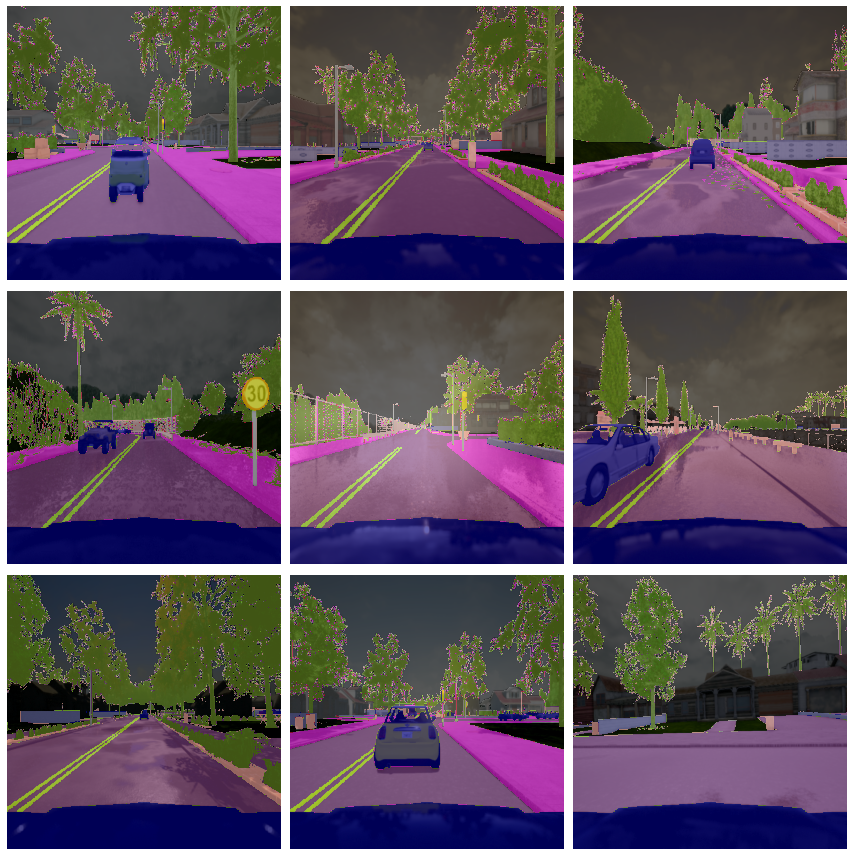

In [149]:
fig = plt.figure(figsize=(12,12))

for i, (rgb, seg) in enumerate(train_data.take(9)):
  ax = fig.add_subplot(3, 3, i + 1)
  ax.set_axis_off()
  ax.grid(False)
  ax.imshow(rgb)
  ax.matshow(seg, cmap=cmap, norm=norm, alpha=0.6)

plt.tight_layout()

In [0]:
def unet_conv_block(input_tensor, filters, last='pool'):
  conv2d_1 = keras.layers.Conv2D(filters, 3,
                                 activation='relu',
                                 padding='same')(input_tensor)
  conv2d_2 = keras.layers.Conv2D(filters, 3,
                                 activation='relu',
                                 padding='same')(conv2d_1)

  if last == 'pool':
    return conv2d_2, keras.layers.MaxPool2D(2, 2)(conv2d_2)
  elif last == 'upsample':
    return keras.layers.Conv2DTranspose(filters//2, 2, 2, padding='same')(conv2d_2)
  else:
    return conv2d_2

def get_unet(input_tensor, classes):
  bn = keras.layers.BatchNormalization()(input_tensor)
  block1, block1_p = unet_conv_block(bn, 64, last='pool')
  block2, block2_p = unet_conv_block(block1_p, 128, last='pool')
  block3, block3_p = unet_conv_block(block2_p, 256, last='pool')
  block4, block4_p = unet_conv_block(block3_p, 512, last='pool')

  block5 = unet_conv_block(block4_p, 1024, last='upsample')

  def crop_size(shape1, shape2):
    top_crop = math.ceil((shape1.shape[1] - shape2.shape[1]) / 2)
    bottom_crop = math.floor((shape1.shape[1] - shape2.shape[1]) / 2)

    left_crop = math.ceil((shape1.shape[2] - shape2.shape[2]) / 2)
    right_crop = math.floor((shape1.shape[2] - shape2.shape[2]) / 2)

    return ((top_crop, bottom_crop), (left_crop, right_crop))

  block4 = keras.layers.Cropping2D(crop_size(block4, block5))(block4)
  block6_in = keras.layers.Concatenate()([block4, block5])
  block6 = unet_conv_block(block6_in, 512, last='upsample')

  block3 = keras.layers.Cropping2D(crop_size(block3, block6))(block3)
  block7_in = keras.layers.Concatenate()([block3, block6])
  block7 = unet_conv_block(block7_in, 256, last='upsample')

  block2 = keras.layers.Cropping2D(crop_size(block2, block7))(block2)
  block8_in = keras.layers.Concatenate()([block2, block7])
  block8 = unet_conv_block(block8_in, 128, last='upsample')

  block1 = keras.layers.Cropping2D(crop_size(block1, block8))(block1)
  block9_in = keras.layers.Concatenate()([block8, block1])
  block9 = unet_conv_block(block9_in, 64, last='none')
  
  block10 = keras.layers.Conv2D(classes, 3, padding='same', activation='softmax')(block9)
  
  return keras.Model(inputs=[input_tensor], outputs=[block10])

In [0]:
unet = get_unet(keras.layers.Input(shape=(512, 512, 3)), 13)
optim = keras.optimizers.Nadam(1e-4)

unet.compile(
  optim, 
  loss=keras.losses.categorical_crossentropy,
  metrics=['accuracy']
)

In [199]:
def one_hot(x, y):
  return x, tf.one_hot(y, 13, axis=2)

train_one_hot = train_data.map(one_hot).take(-1).batch(4)
valid_one_hot = valid_data.map(one_hot).take(-1).batch(4)
unet.fit(train_one_hot, validation_data=valid_one_hot, epochs=10)

Epoch 1/10
150/150 [==============================] - 98s 651ms/step - loss: 1.5487 - accuracy: 0.4752 - val_loss: 1.5616 - val_accuracy: 0.4862
Epoch 2/10
150/150 [==============================] - 97s 649ms/step - loss: 1.2587 - accuracy: 0.5825 - val_loss: 1.2006 - val_accuracy: 0.5985
Epoch 3/10
150/150 [==============================] - 97s 648ms/step - loss: 0.9797 - accuracy: 0.6842 - val_loss: 0.8647 - val_accuracy: 0.7307
Epoch 4/10
150/150 [==============================] - 97s 649ms/step - loss: 0.8277 - accuracy: 0.7332 - val_loss: 0.7002 - val_accuracy: 0.7823
Epoch 5/10
150/150 [==============================] - 97s 647ms/step - loss: 0.6848 - accuracy: 0.7869 - val_loss: 0.5707 - val_accuracy: 0.8337
Epoch 6/10
150/150 [==============================] - 97s 647ms/step - loss: 0.5719 - accuracy: 0.8333 - val_loss: 0.5960 - val_accuracy: 0.8206
Epoch 7/10
150/150 [==============================] - 97s 649ms/step - loss: 0.4949 - accuracy: 0.8567 - val_loss: 0.4417 - val_ac

In [0]:
for x, y in valid_data.take(1):
  x = x
  y = y

In [0]:
y_pred = unet(tf.expand_dims(x, 0))
y_pred = tf.argmax(y_pred, axis=3)

(-0.5, 511.5, 511.5, -0.5)

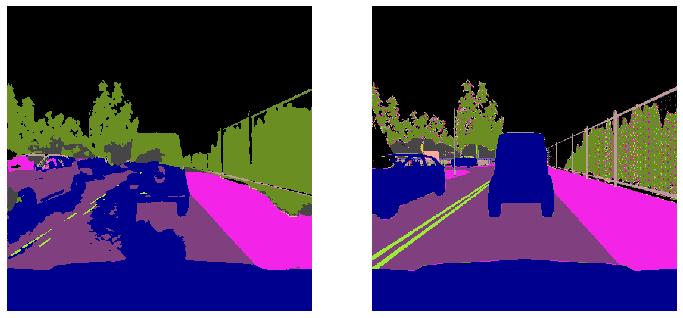

In [218]:
fig, ax = plt.subplots(1, 2, figsize=(12,12))

ax[0].matshow(y_pred[0, :, :], cmap=cmap, norm=norm)
ax[0].grid(False)
ax[0].axis('off')

ax[1].matshow(y, cmap=cmap, norm=norm)
ax[1].grid(False)
ax[1].axis('off')


It's not as good as I'd like, but this can be solved with more data and better metrics/training which I'll do later...zzZZzZ 